<a href="https://colab.research.google.com/github/bounabyazid/COVID-19-TweetIDs/blob/master/Tweets_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import re
import sys
import json 

import pickle
import scipy.io
from scipy import stats 
import numpy as np
import seaborn as sns
from pprint import pprint

import matplotlib.pyplot as plt

!pip install spacy
import spacy
!python -m spacy download en_core_web_sm

!pip install gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

!pip install wordcloud
from wordcloud import WordCloud

!pip install nltk
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize

nltk.download('punkt')
nltk.download('stopwords')

!pip install urlextract
from urlextract import URLExtract

!pip install pyLDAvis

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from google.colab import drive

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
path = '/content/drive/My Drive/Data Science Research Group/COVID-19 Project/data extraction/january/'
path = '/content/drive/My Drive/Paraphrase Detection/'

Months = ['january']

def LoadDataset(FileName):
    with open(FileName,'r') as f:
         Data = json.load(f)
    Data = [re.sub('RT\s.*?:', '',y['full_text']) for x in Data for y in x]
    return Data

def Replace_Text(Text, Punct, New):
    for Old in Punct:
        if isinstance(Old, tuple):
           Text = Text.replace(Old[0], Old[1])
        else:
            Text = Text.replace(Old, New)
    return Text

def ReplaceChunk(Text, List, newvalue):
    NewText = Text
    for item in List:
        NewText = NewText.replace(item, newvalue)
    return re.sub(' +', ' ', NewText)

def Word_Cloud(Texts):
    Texts = re.sub('[,\.!?]', '', Texts)    
    Texts = Texts.lower()    
    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=10000, contour_width=5, contour_color='steelblue',width=900, height=600)
    # Generate a word cloud
    wordcloud.generate(Texts)
    # Visualize the word cloud
    wordcloud.to_image()

In [0]:
def General_preprocessing(Texts):
    Text = ' \n '.join(Texts)
    
    extractor = URLExtract()
    Urls = extractor.find_urls(Text)
    Text = ReplaceChunk(Text, Urls, ' ')
    #________________________________________________
    Acro = [X for X in list(set(re.findall('(?:(?<=\.|\s)[A-Z]\.)+',Text))) if len(X) >= 4]
    Filtred = [AC.replace(".", "") for AC in Acro]
    Text = Replace_Text(Text, list(zip(Acro, Filtred)), None)
    #________________________________________________
    Text = re.sub('\(.*?\)', '', Text)
    Text = re.sub(r'@\S+', '', Text)
    #________________________________________________
    Punct = ['.', '?', '!', '…', ':', ',', '⚠', '️', '/', '-', '_', '|', 
             '“', '”', '’', "'", '\xa0', '—', '▪', '"', ';', "😬", "🤔",'(',')']
    Text = Replace_Text(Text, Punct, '')   
    #________________________________________________
    Text = re.sub(' +', ' ', Text).lower()
    Tokens = Text.split(' ')

    Tokens = [word for word in Tokens if not word in stopwords.words() or len(word) > 3]
    
    Texts = ' '.join(Tokens).strip()
    Texts = [x.strip() for x in Texts.split('\n') if x.strip()]
    
    return Texts

In [48]:
Data = LoadDataset('result-tweet-id-2020-01-21.json')
Texts = General_preprocessing(Data)
print(Texts[:10])

['activated emergency operations center', 'they expect more us cases', '#coronavirus', 'where federal vaccination education campaign hpv where federal #lungcancer screening program', 'breaking news first us case wuhan coronavirus been confirmed washington state federal officials said th', 'should noted that cdc initially embargo placed cdc testimony trump administration lifted', 'with cdc confirming first case wuhan coronavirus here united states seattle washington there', 'phap gives future #publichealth professionals critical frontline experience apply', 'breaking cdc expected announce first case new strain coronavirus ncov washington state', 'us centers disease control confirmed diagnosed first case newlyidentified wuhan coronavirus']


# **Word Cloud of the most frequent words in terms of frequency**

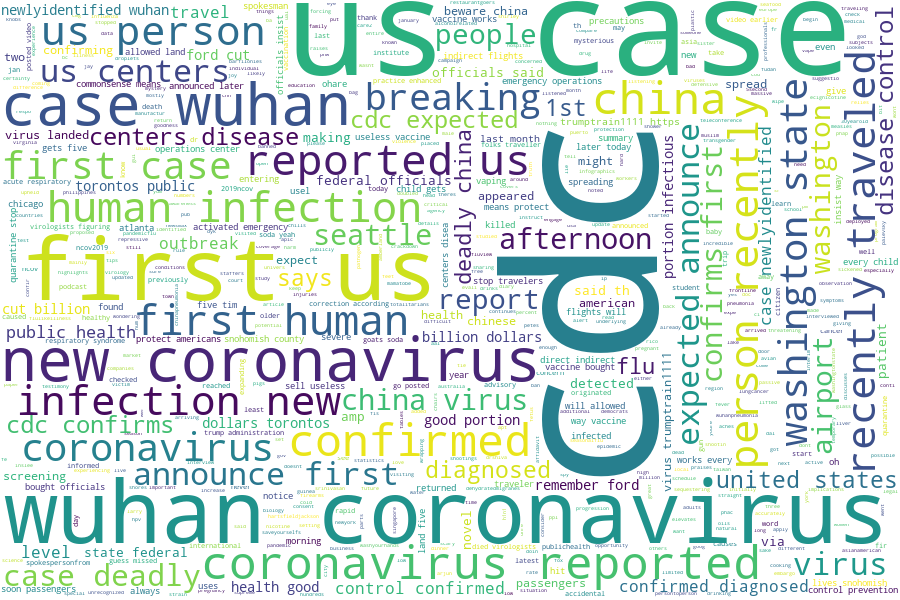

In [49]:
wordcloud = WordCloud(background_color="white", max_words=10000, contour_width=5, contour_color='steelblue',width=900, height=600)
# Generate a word cloud
wordcloud.generate('\n'.join(Texts))
# Visualize the word cloud
wordcloud.to_image()

In [0]:
def make_bigrams(Texts,bigram_mod):
    return [bigram_mod[doc] for doc in Texts]

def lemmatization(Texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    nlp.max_length = 21085330

    texts_out = []
    for sent in Texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
    
def sent_to_words(Sentences):
    for sentence in Sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))# deacc=True removes punctuations


In [67]:
print(Texts)

['activated emergency operations center', 'they expect more us cases', '#coronavirus', 'where federal vaccination education campaign hpv where federal #lungcancer screening program', 'breaking news first us case wuhan coronavirus been confirmed washington state federal officials said th', 'should noted that cdc initially embargo placed cdc testimony trump administration lifted', 'with cdc confirming first case wuhan coronavirus here united states seattle washington there', 'phap gives future #publichealth professionals critical frontline experience apply', 'breaking cdc expected announce first case new strain coronavirus ncov washington state', 'us centers disease control confirmed diagnosed first case newlyidentified wuhan coronavirus', 'coronavirus health officials announce first known us case', 'cdc just confirmed first american case wuhan coronavirus 6 people have died virologists figuring', 'us centers disease control confirmed diagnosed first case newlyidentified wuhan coronaviru

In [0]:
def LDA(Texts):
    data_words = list(sent_to_words(Texts))

    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    #trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    #trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words,bigram_mod)

    return data_words_bigrams

def LDA2(data_words_bigrams):  
    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)

    # Create Corpus
    texts = data_lemmatized

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    
    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    
    pprint(lda_model.print_topics())
    doc_lda = lda_model[corpus]
    
    # Compute Perplexity
    print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)
    
    return lda_model,id2word,corpus

In [69]:
data_words_bigrams = LDA(Texts)
print(data_words_bigrams)

[['activated', 'emergency', 'operations', 'center'], ['they', 'expect', 'more', 'us', 'cases'], ['coronavirus'], ['where', 'federal', 'vaccination', 'education', 'campaign', 'hpv', 'where', 'federal', 'lungcancer', 'screening', 'program'], ['breaking', 'news', 'first', 'us', 'case', 'wuhan', 'coronavirus', 'been', 'confirmed', 'washington', 'state', 'federal', 'officials', 'said', 'th'], ['should', 'noted', 'that', 'cdc', 'initially', 'embargo', 'placed', 'cdc', 'testimony', 'trump', 'administration', 'lifted'], ['with', 'cdc', 'confirming', 'first', 'case', 'wuhan', 'coronavirus', 'here', 'united', 'states', 'seattle', 'washington', 'there'], ['phap', 'gives', 'future', 'publichealth', 'professionals', 'critical', 'frontline', 'experience', 'apply'], ['breaking', 'cdc', 'expected', 'announce', 'first', 'case', 'new', 'strain', 'coronavirus', 'ncov', 'washington', 'state'], ['us', 'centers', 'disease', 'control', 'confirmed', 'diagnosed', 'first', 'case', 'newlyidentified', 'wuhan', 'c

In [70]:
lda_model,id2word,corpus = LDA2(data_words_bigrams)

[(0,
  '0.069*"set" + 0.059*"truth" + 0.059*"shall" + 0.059*"free" + 0.049*"beware" '
  '+ 0.049*"return" + 0.025*"diagnose" + 0.025*"break" + 0.025*"fir" + '
  '0.025*"summary"'),
 (1,
  '0.029*"commonsense" + 0.029*"protect" + 0.029*"stop" + 0.029*"mean" + '
  '0.029*"enter" + 0.029*"amp" + 0.019*"podcast" + 0.019*"outbreak" + '
  '0.019*"day" + 0.019*"interview"'),
 (2,
  '0.069*"confirm" + 0.059*"late" + 0.059*"here" + 0.051*"gui" + '
  '0.051*"interim" + 0.050*"there" + 0.033*"state" + 0.030*"vape" + '
  '0.030*"emergency" + 0.030*"activate"'),
 (3,
  '0.096*"get" + 0.071*"know" + 0.069*"vaccine" + 0.053*"nee" + '
  '0.044*"official" + 0.035*"sell" + 0.035*"useless" + 0.035*"buy" + '
  '0.035*"way" + 0.035*"work"'),
 (4,
  '0.132*"say" + 0.081*"infect" + 0.081*"chinese" + 0.080*"virus" + '
  '0.048*"land" + 0.024*"arrive" + 0.024*"originate" + 0.024*"should" + '
  '0.020*"visit" + 0.015*"washingtonstate"'),
 (5,
  '0.085*"will" + 0.079*"airport" + 0.075*"passenger" + 0.048*"flight

In [71]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14    -0.209072 -0.337074       1        1  18.204296
11    -0.330858  0.089658       2        1  11.149462
18    -0.271467  0.081524       3        1   9.406677
1      0.104055  0.044407       4        1   5.864437
7     -0.172050  0.071019       5        1   5.594098
5      0.064000 -0.098338       6        1   5.204706
17    -0.156187  0.092796       7        1   4.579438
2      0.031057  0.086307       8        1   4.133185
6      0.100489  0.044136       9        1   3.980927
3      0.083732  0.014301      10        1   3.677608
13     0.049292 -0.139378      11        1   3.609894
15     0.087874  0.041382      12        1   3.496483
9      0.101617  0.045825      13        1   3.349111
4      0.069606 -0.052809      14        1   3.346118
10     0.064589 -0.051531      15        1   3.166192
0      0.058185  0.002555      16        1   2.905720
16     0.088503  0.024756      17        1   2.599758
8      0.085605  0.023050      18        1   2.274512
12     0.094258  0.044661      19        1   2.228944
19     0.056771 -0.027243      20        1   1.228442, topic_info=           Term      Freq      Total Category  logprob  loglift
3          case  68.00000  68.000000  Default  30.0000  30.0000
16      confirm  41.00000  41.000000  Default  29.0000  29.0000
17        first  70.00000  70.000000  Default  28.0000  28.0000
38          new  31.00000  31.000000  Default  27.0000  27.0000
75        virus  20.00000  20.000000  Default  26.0000  26.0000
..          ...       ...        ...      ...      ...      ...
316         ban   0.02528   2.052054  Topic20  -6.4667   0.0029
302        word   0.02528   2.082260  Topic20  -6.4667  -0.0118
356        care   0.02528   1.495500  Topic20  -6.4667   0.3192
360   transgend   0.02528   1.495500  Topic20  -6.4667   0.3192
359  repressive   0.02528   1.495500  Topic20  -6.4667   0.3192

[850 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
377      11  0.829193  accidental
243       9  0.524416      accord
243      13  0.524416      accord
218       4  0.668673  accurately
0         8  0.850714    activate
...     ...       ...         ...
104      10  0.828073        work
406      17  0.452847      worker
323      13  0.757505       would
395      18  0.503876        wrap
340       9  0.914249        year

[405 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 12, 19, 2, 8, 6, 18, 3, 7, 4, 14, 16, 10, 5, 11, 1, 17, 9, 13, 20])